<a href="https://colab.research.google.com/github/kel-c-lm/translator/blob/main/OldEnglishTranslator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Old English is very little like the English we know today. Modern English is separated from Old English by nearly 1000 years, several grammatical cases, and a vowel shift so profound we call it "The Great Vowel Shift." The result of this separation is that Old English is basically incomprehensible to Modern English speakers, rendering the original text of Beowulf as opaque, cryptic, and frankly disconcerting as the directoral choices behind it's film adaptation. 

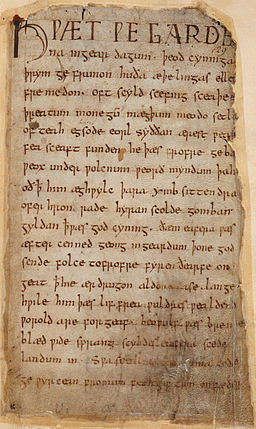


Considering the huge span of time and syntax that separate Modern English from Old English, I thought it might be fun to experiment a little with machine aided translation of Old English. 

Machine translation has made incredible progress in recent years. Current machine learning models have replaced older statistical methods, like IBM's [alignment models](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1162/handouts/Collins_annotated.pdf), in which each word in each sentence in a source language had to be painstakingly aligned to the corresponding word in a target language. The field continues to make progress in the realms of historic and low-resource languages through the advent of non-parallel translation, like what MIT's CSAIL recently used to [decipher ancient text](https://www.csail.mit.edu/news/translating-lost-languages-using-machine-learning). 

This post is designed to walk you through the process of implementing a model for parallel machine aided translation. The code is all executable, if you'd like to follow along in Google Colab. If you choose to do so, after opening this notebook in Colab, be sure to go to Edit -> Notebook Settings, and then, in the dropdown menu under Hardware Accelerator, select GPU and save. Unless you have far more patience than I do, this is necessary to speed up the training process.




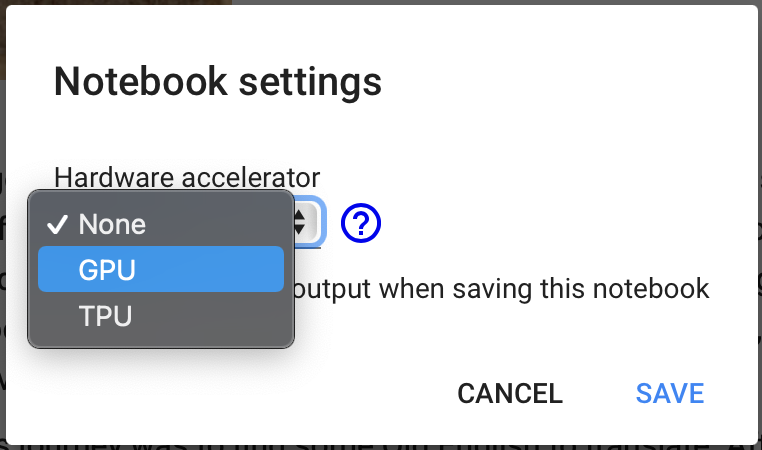

The first step in this process was to find some Old English to translate. After careful consideration, I settled on *The Homilies of the Anglo-Saxon Church or Homilies of Ælfric*. There were a couple of factors motivating that choice. The text is long, largely uncorrupted, and, importantly, there is a digital edition, complete with parallel translation, freely available from [Project Gutenberg](https://https://www.gutenberg.org/files/38334/38334-h/38334-h.htm). The parallel translations are important, because the next step was to line the source sentences (i.e. the Old English ones) up with the target sentences (i.e. the Modern English ones). A fairly direct, line-by-line translation is important for parallel machine translation. Other sources considered were *The Dialogues of Solomon and Saturn*, which is relatively short with quite a bit of poetry in the mix, and *The Old English Martyrology*, which is a very long list of horrible deaths kept by a group of what I'm assuming were extremely distraught monks. While promising for its length, the *Martyrology* ultimately had too much orthographic variation and too many proper nouns for use in this project. The text of the *Homilies* was scraped using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), and the source and target sentences were paired computationally, and then manually proofed. 

There are a lot of problems that come up when dealing with historical languages in this manner. Orthographic variation is one. Each new spelling of a word is treated as unique by the model we're creating. This is the reason I stuck with one source for creating the corpus. While orthographic variation still occured, it was less frequent than it would have been had I used several sources. The existence (or lack thereof) of parallel text is another problem. Much of what I was able to find parallel translations of was poetry, and poets tend to take a lot of creative license with their translations. This is their prerogative, but it's not particularly useful for the purposes of training a machine translation model. Another problem I ran into is lack of punctuation. Ælfric the Monk had a tendency to ramble. Many of his sentences were hundreds of words long, with nary a semicolon or period in sight. For the sake of simplicity, I used only the shortest and simplest sentences and phrases that I could find. I supplemented these by changing one element of some of these sentences, such as person or negation where I felt my knowledge of Old English was sufficient, and included these as separate sentences. Still, the corpus is quite, quite small, and one of the many things I'd like to do with this project in the future is try to expand this corpus. 

If you're following along, executing the next cell by pressing play will snag the corpus from this project's Github repository. 

In [ ]:
!wget https://github.com/kel-c-lm/translator/raw/main/oeCorpus.tsv

Now that we've got our data, it's time to create our model. The model that we're going to build is based on Jason Brownlee's German/English translation [model](https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/), with a few modifications to the cleaning process, as well as the model itself. The first step is to make our imports. These should all be ready to go in Colab by default, so there should be no need to download anything. These are all the packages we'll need to build and run our model, and to evaluate it when we're done. 

In [ ]:
import string
import re
import pandas as pd
from unicodedata import normalize
from pickle import load
from pickle import dump
from numpy import array
from numpy import argmax
from numpy.random import rand
from numpy.random import shuffle
from tensorflow import keras
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

Now that the imports are out of the way, let's clean up our data. The following code does some pretty run of the mill NLP stuff, like normalizing everything to lower case, and taking care of excess whitespace, punctuation, and numerals. The code below should output a list of 20 pairs of Modern English and Old English sentences, punctuation-less and in lower case. 

In general, it's good practice when preparing a dataset for machine translation to replace all words that appear fewer than a certain number of times (say, 5), with the token UNK (short for unknown). This ensures that the model doesn't panic upon finding a word that it hasn't seen before, or that it's only seen a few times. With a corpus this small, however, that isn't practical; there would be too many unknown words. This corpus has been cleaned of unique words by filtering out sentences that contain hapaxes (words that only appear once in a corpus.) 

In [ ]:
MAX_LENGTH = 20

def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def to_pairs(doc):
  lines=doc.strip().split('\n')
  pairs=[line.split('\t') for line in lines]
  pairs = [pair for pair in pairs if filterPair(pair)]
  pairs = [list(reversed((p))) for p in pairs]
  return pairs

def clean_pairs(lines):
	cleaned = list()
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			line = line.split()
			line = [word.lower() for word in line]
			line = [word.translate(table) for word in line]
			line = [word for word in line if word.isalpha()]
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

filename = 'oeCorpus.tsv'
doc = load_doc(filename)
pairs = to_pairs(doc)
clean_pairs = clean_pairs(pairs)
save_clean_data(clean_pairs, 'me-oe.pkl')
for i in range(20):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

The following shuffles our sentences, and splits them into a training set and a test set. We'll train our model on 90% of the data, and test it on 10%. 

In [ ]:
 
dataset = load_clean_sentences('me-oe.pkl')
shuffle(dataset)
pairs_length = len(pairs)
ninety_percent = int(len(pairs)*.9)
ten_percent = pairs_length-ninety_percent

train, test = dataset[:336], dataset[336:]
save_clean_data(dataset, 'me-oe-both.pkl')
save_clean_data(train, 'me-oe-train.pkl')
save_clean_data(test, 'me-oe-test.pkl')

Let's break down what the following code does. First, it tokenizes the text, which is just a fancy way of saying that it breaks it down into individual words. Then it encodes those words. Input sequences (the source language) are intenger encoded, meaning that each unique word is assigned a number. Output sequences (the target language) are one-hot encoded, meaning that each word is mapped to a binary vector (i.e. assigned a spot in a matrix of ones and zeroes. Just like The Matrix. You get used to it. I-I don't even see the code. All I see is noun, verb, preposition...) This code also builds our model. It has 6 layers: an input layer, an embedding layer, which groups similar words together, two LSTM (long short-term model) layers, which learn from the order of words in a sentence, a repeat vector layer, which repeats the input a certain number of times, and an output layer. A schematic of the model can be found below.

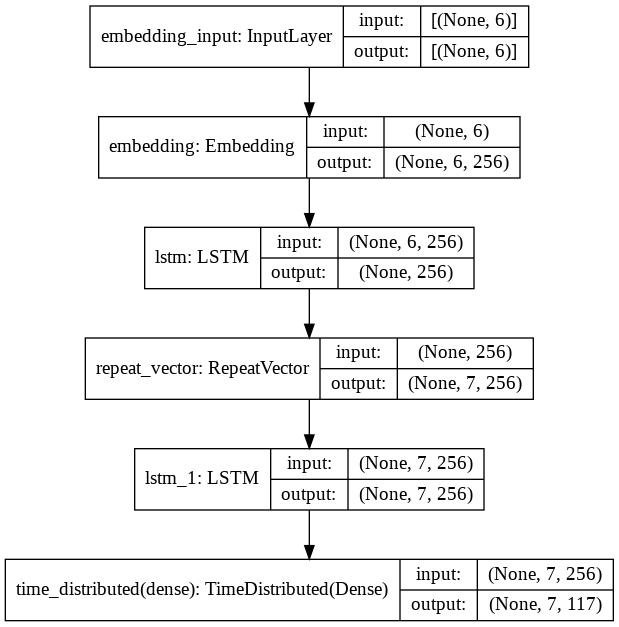

In [ ]:

def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(lines):
	return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
	X = tokenizer.texts_to_sequences(lines)
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

dataset = load_clean_sentences('me-oe-both.pkl')
train = load_clean_sentences('me-oe-train.pkl')
test = load_clean_sentences('me-oe-test.pkl')


eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

oe_tokenizer = create_tokenizer(dataset[:, 1])
oe_vocab_size = len(oe_tokenizer.word_index) + 1
oe_length = max_length(dataset[:, 1])
print('Old English Vocabulary Size: %d' % oe_vocab_size)
print('Old English Max Length: %d' % (oe_length))

trainX = encode_sequences(oe_tokenizer, oe_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

testX = encode_sequences(oe_tokenizer, oe_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)


The following code implements the model and runs it. This is where there's a lot of room for fiddling around with what are called hyperparameters: things like the number of epochs (training cycles), the initial learning rate (which controls changes in response to errors), the batch size (the number of samples the model sees at one time), and the number of nodes (computational units with a certain weight; if an input meets or exceeds this weight, the node will activate). These can be thought of like knobs that you adjust to tune the model. Here, we're training for 200 epochs, the learning rate initializes to 0.1, the batch size is 64, and there are 256 nodes. 

The output of this code will update you every epoch on two important numbers: loss and validation loss (val_loss). The loss indicates how well or poorly the model does when comparing it's predictions to the training data. Validation loss indicates how well or poorly the model does when comparing it's prediction to the test data. In general, the closer those numbers are to zero, the better. Low loss with high validation loss indicates your model is overfitting: learning how to parrot the training data, but not how to predict the test data. As long as these two numbers remain relatively close together, while also approaching zero, you can assume the model is learning. This model checkpoints every time the model improves, (i.e. every time the validation loss decreases). 

In [ ]:
model = define_model(oe_vocab_size, eng_vocab_size, oe_length, eng_length, 256)
model.compile(optimizer='Adam', loss='categorical_crossentropy')
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

model_filename = 'model.h5'
checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
initial_learning_rate = 0.1
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
history_time_based_decay = model.fit(
    trainX, 
    trainY, 
    epochs=200, 
    validation_data=(testX, testY),
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1), checkpoint],
)

Here it is. The moment of truth. The following code evaluates your model. The first bit of output will be the training data. This is all the data that your model saw and learned from throughout the training phase. The second bit is the most important bit: the testing data. This should consist solely of data that the model did not learn from during training. The output will also be evaluated using BLEU, a metric for evaluating machine translations. A score of 1 is perfect, (although nearly impossible to attain,) and a score of 0 is... well, a score of 0. 

In [ ]:

def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(lines):
	return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
	X = tokenizer.texts_to_sequences(lines)
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 40:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

dataset = load_clean_sentences('me-oe-both.pkl')
train = load_clean_sentences('me-oe-train.pkl')
test = load_clean_sentences('me-oe-test.pkl')

eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

oe_tokenizer = create_tokenizer(dataset[:, 1])
oe_vocab_size = len(oe_tokenizer.word_index) + 1
oe_length = max_length(dataset[:, 1])

trainX = encode_sequences(oe_tokenizer, oe_length, train[:, 1])
testX = encode_sequences(oe_tokenizer, oe_length, test[:, 1])


model = load_model('model.h5')

print('train')
evaluate_model(model, eng_tokenizer, trainX, train)

print('test')
evaluate_model(model, eng_tokenizer, testX, test)

When I run this code, I come up with a BLEU score of around .7 or .8. This isn't bad. As I mentioned, however, the corpus is vanishingly small. I'd like to work on expanding that corpus. Since part of the problem here lies in the scarcity of parallel Modern English to Old English text, this might be a good application for non-parallel machine translation, which is another avenue I'd like to look at in the future. 

In short, I'm happy with the way this translator works. It performs better with function words than it does with content words, for the reason that it was trained on far more function words than content words, function words being far more common. Although there's quite a bit of room for improvement, it works well as a proof of concept. 

#References and suggestions for further reading

*You Look Like a Thing and I Love You* by Janelle Shane offers a hilarious look at machine learning through knock-knock jokes, recipes, and pick-up lines generated by models such as Google's GPT-2. 

Sebastian Ruder's [NLP blog](https://ruder.io) is also a great place to look for updates and opinions on all things NLP. 



[1] Ælfric, Abbot of Eynsham, and Benjamin Thorpe. The Homilies of the Anglo-Saxon Church: The First Part Containing the Sermones Catholici, or Homilies of Aelfric in the Original Anglo-Saxon, with an English Version. Fleet Street: Richard and John E. Taylor, 1846. Retrieved from https:/www.gutenberg.orgfiles3833438334-h38334-h.htm

[2] Anlezark, Daniel The Old English Dialogues of Solomon and Saturn. Woodbridge: Boydell & Brewer, 2009. Retrieved from https:/jstor.orgstable10.7722j.ctt9qdknr.9.

[3] Johnson, Keith. A History of Early EnglishLondon: ROUTLEDGE, 2016.

[4] Luo, Jiaming, Frederik Hartmann, Enrico Santus, Regina Barzilay, and Yuan Cao. “Decipher- ing Undersegmented Ancient Scripts Using Phonetic Prior.” Transactions of the Association for Computational Linguistics 9 (2021): 69–81. https:/doi.org10.1162tacl_a_00354.

[5] Papineni, Kishore, Salim Roukos, Todd Ward, and Wei-Jing Zhu. “BLEU: a Method for Auto- matic Evaluation of Machine Translation.” Proceedings of the 40th Annual Meeting on Associ- ation for Computational Linguistics - ACL ’02, 2001. https:/doi.org/10.31151073083.1073135.

[6] University of Oxford. Helsinki corpus of English texts, Oxford Text Archive (1991) http://hdl.handle.net/20.500.12024/1477.

[7] Rauer, Christine. Old English Martyrology. D S Brewer, 2016. Retrieved from https:/www.jstor.orgstable10.7722j.ctt31njnj.7.

[8] hang, Aston, Zachary C Lipton, Mu Li, and Alexander J Smola.Zhang et al. 2021 “Dive into Deep Learning.” 9.5. Machine Translation and the Dataset - Dive into Deep Learning 0.16.3 documentation, 2021. https:/d2l.ai/chapter_recurrent-modern/machine-translation- and-dataset.html.